# Evaluation

The goal of this lab is to introduce you the most important techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We start with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. In a nut shell the iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family (iris setosa, iris versicolor, iris virginica). It was first used by Fisher to introduce linear discriminant analysis. Our version of the data set has 150 data points with 50 for each class.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


As a first example we try to classify the iris versicolor with the help of the first two features (that makes visualisation simpler as we do not know PCA yet). 

In [2]:
import numpy as np

X_versi = X[:, :2]

y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

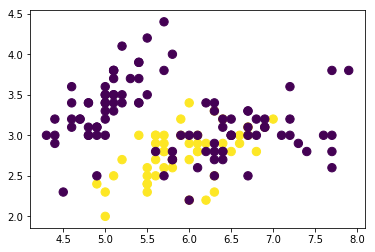

In [3]:
plt.scatter(X_versi[:, 0], X_versi[:, 1], c=y_versi, s=70)

The scatter plot shows that this is going to be a hard seperation problem as the classifier has to predict the red points. 

We split the data into a train and test (holdout) set.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, random_state=3)
train_test_split?

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [5]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

Text(0.5,1,'Decision function of a SVM classifier with gamma = 10, C = 1')

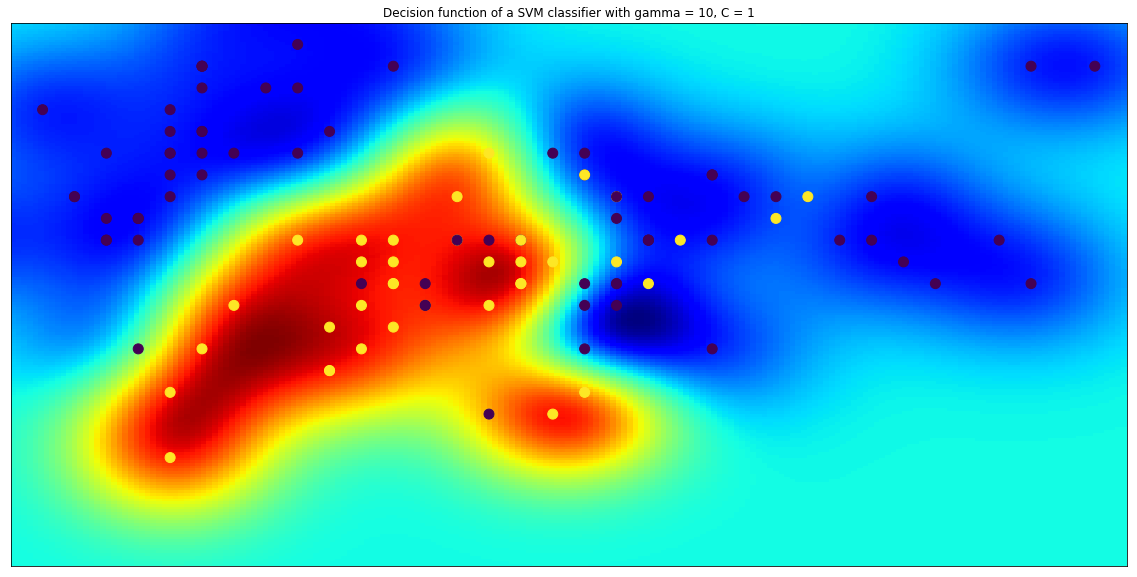

In [6]:
from sklearn.svm import SVC


clf_svm = SVC(gamma=10, C=1)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1')

The scikit-learn metrics package offers the basic evaluation routines.

In [7]:
from sklearn import metrics

y_pred = clf_svm.predict(X_test)

print("Test Precision: {}".format(metrics.precision_score(y_test, y_pred)))
print("Test Recall: {}".format(metrics.recall_score(y_test, y_pred)))
print("Test F-Score: {}".format(metrics.f1_score(y_test, y_pred)))

Test Precision: 0.6666666666666666
Test Recall: 0.5
Test F-Score: 0.5714285714285715


Recalling the definition of precision and recall the numbers mean that 2/3 of the positive predictions are correct and that 1/2 of the test iris versicolor has been found by the classifier. The F-Score is then just the arithmetic mean of both (7/12).

To plot the ROC curve the decision function needs to be explicitly evaluated. The following code block also contains a helper function to plot ROC curves.

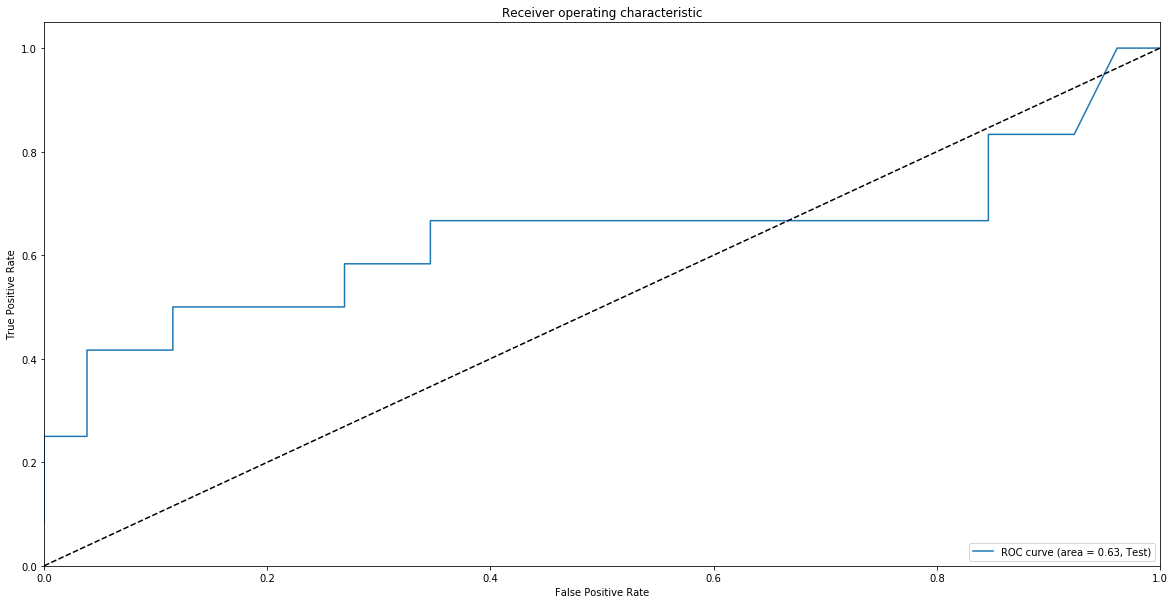

In [40]:
y_score = clf_svm.decision_function(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)


# helper to plot ROC curves
def plot_roc_curves(fprs, tprs, names):
    fig = plt.figure(figsize=(20,10))
    for fpr, tpr, name in zip(fprs, tprs, names):
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f, %s)' % (metrics.auc(fpr, tpr), name))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc_curves([fpr], [tpr], ["Test"])

<b>Ex. 1.1</b>: Train four different classifiers (on the train/test data we used in the prior example) and put them into the list 'clfs' (you can add elements to a list via the 'append' method. Analyse the visualisations that are created by the code blocks after (Is there a uniquely best classifier?). Set the $\gamma$ parameter to $1$ and vary the $C$. Before trying out values be sure to check the <a href="http://scikit-learn.org/stable/modules/svm.html">SVM</a> documentation in scikit-learn.

Hint: Set a name to your classifier, i.e. clf.name = "Some description" to keep track of what you have done.

In [9]:
# Exercise 1.1
clfs = []

In [18]:
# Solution Exercise 1.1

clfs = []
Cs = [0.1, 1, 10, 25]
for C in Cs:
    clf = SVC(gamma=1, C=C)
    clf.fit(X_train, y_train)
    clf.name = 'C = {}'.format(C)
    clfs.append(clf)

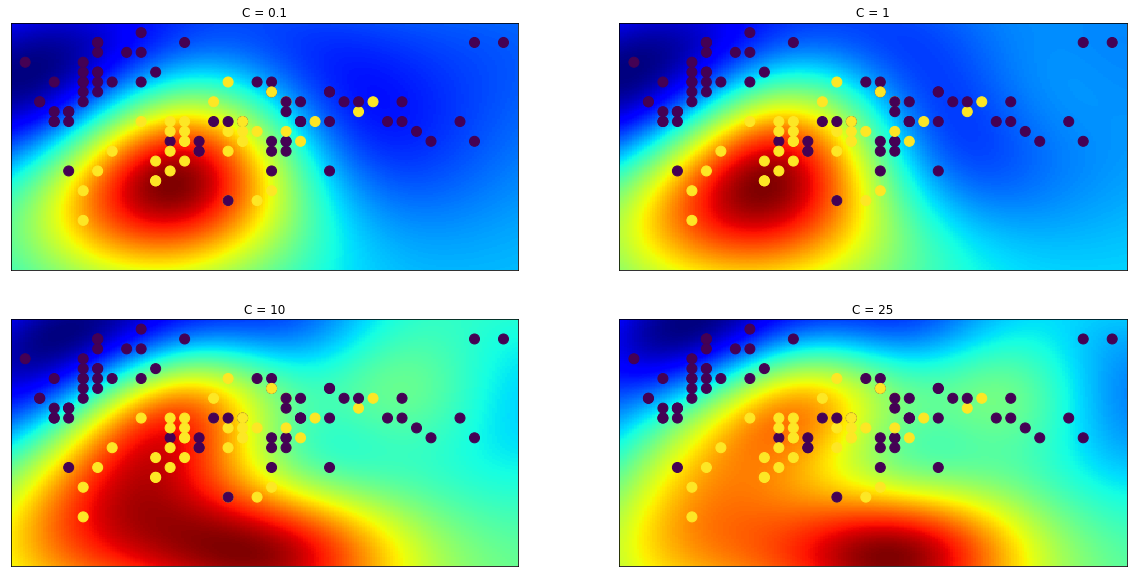

In [19]:
# This code visualises the decision functions of the four different classifiers.

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

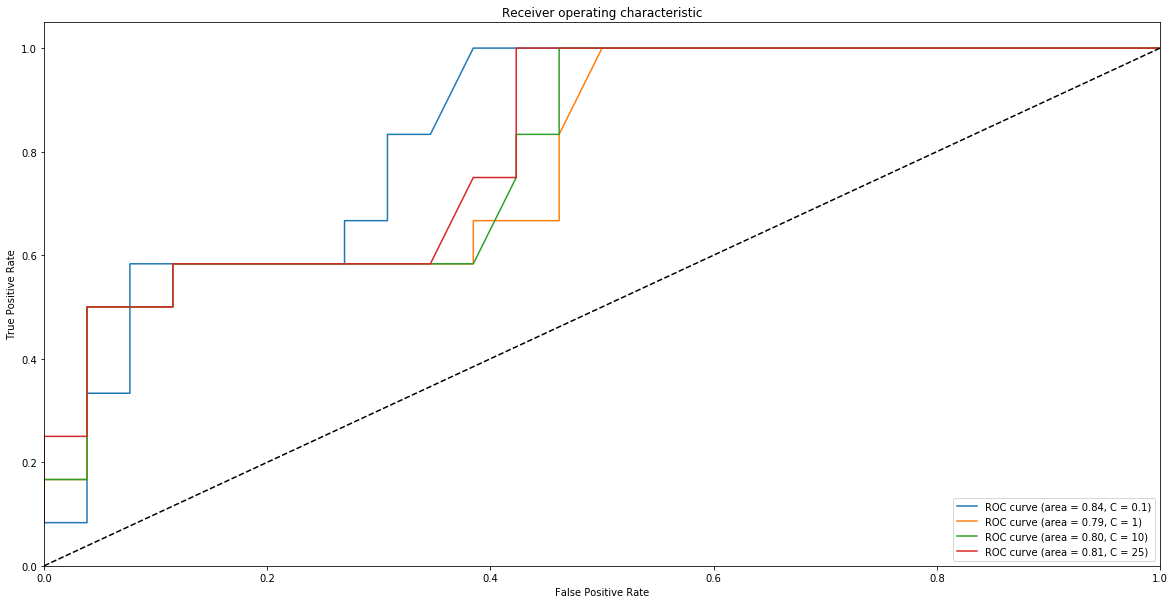

In [41]:
# draw the roc curves.

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
names = [clf.name for clf in clfs]
plot_roc_curves(fprs, tprs, names)

## 2. Cross-Validation

Having only 150 samples it seems like a waste to waste 30% of the training samples into the holdout set. To avoid this we can use CV - as presented in the lecture - to trade computational power for a better use of our data. 

The following code creates a list of masks, where every mask can be used as an index set to select the test samples.

[[ 4.6  3.2]
 [ 4.6  3.1]
 [ 5.4  3.4]
 [ 5.   3. ]
 [ 5.7  4.4]
 [ 7.7  2.6]
 [ 5.5  2.5]
 [ 4.6  3.4]
 [ 6.3  2.9]
 [ 6.7  3.1]
 [ 5.6  3. ]
 [ 4.4  3. ]
 [ 5.8  2.6]
 [ 5.5  2.3]
 [ 6.7  3.1]]
135


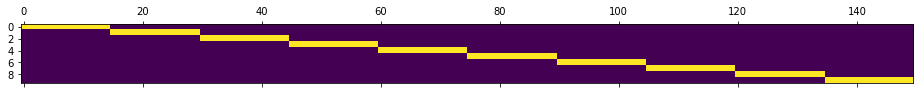

In [24]:
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples // k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*fold_size:(i+1)*fold_size] = True
        masks.append(mask)
        
    return masks

masks = create_kfold_mask(150, 10)
plt.matshow(masks)

mask = masks[0]
print(X_versi[mask]) # selects the test sample
print(len(X_versi[~mask])) # selects training sample, ~ is binary negation

Since the data is sorted by the labels the $k$-fold CV will likely have trouble with class imbalances in the some cases. A random shuffle solves this problem.

In [25]:
print(y_versi)
num_sample = len(X_versi)
np.random.seed(3)
permutation = np.random.permutation(num_sample)
X_versi, y_versi = X_versi[permutation], y_versi[permutation]

[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.
  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.
  0.  0.  0.  0.  0.  0.]


<b>Ex. 2.1</b>: Implement the function scores = cv_k_fold_classifier(clf, k, X, y) that fits the classifier clf on the k-fold cvs of X and y. It returns two lists of scores: the training and test scores of each fold. Interpret the results of the code block after.

In [26]:
# Exercise 2.1

def cv_k_fold_classifier(clf, k, X, y):
    training_scores = []
    test_scores = []
        
    # Your code

    return training_scores, test_scores
    

In [27]:
# Solution Exercise 2.1

def cv_k_fold_classifier(clf, k, X, y):
    training_scores = []
    test_scores = []
   
    # Your code
    n = len(X)
    masks = create_kfold_mask(n, k)
    
    for mask in masks:
        X_train, y_train = X[~mask], y[~mask]
        clf.fit(X_train, y_train)
        training_scores.append(clf.score(X_train, y_train))
        
        X_test, y_test = X[mask], y[mask]
        test_scores.append(clf.score(X_test, y_test))
    
    return training_scores, test_scores

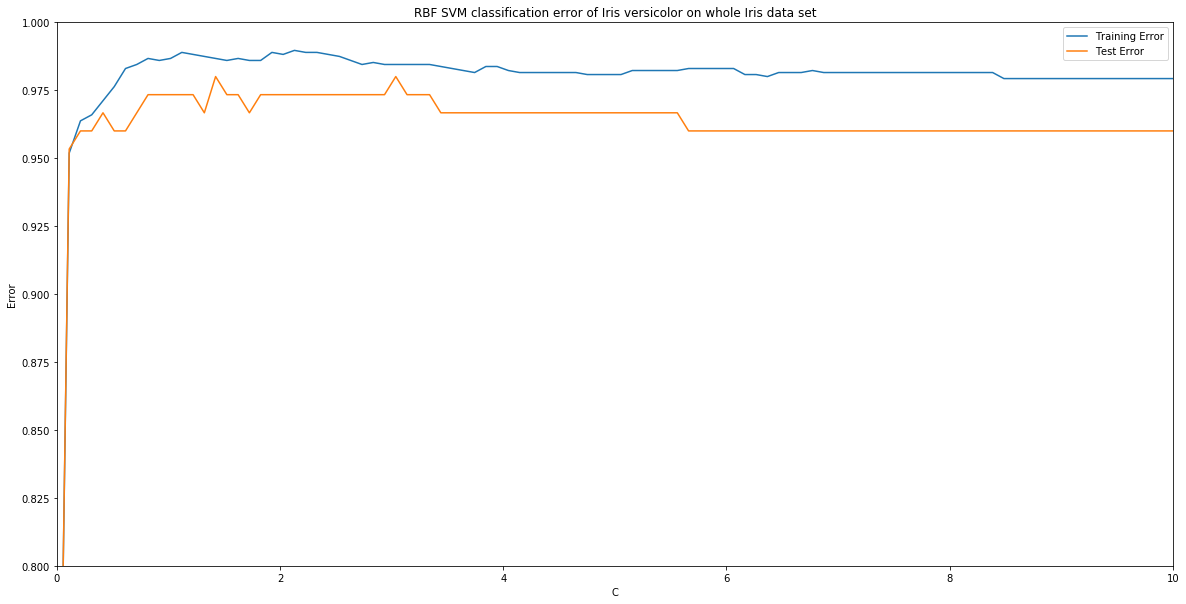

In [28]:
# Train SVM with complete data now and use k-fold CV
# still needs to shuffle data
X_versi_2 = X[permutation]

y_versi_2 = np.zeros(len(y))
y_versi_2[y == 1] = 1
y_versi_2 = y_versi_2[permutation]

Cs = np.linspace(0.01, 10, 100)

training_scores = []
test_scores = []


for C in Cs:
    clf = SVC(C=C)
    clf.name = "SVM with C = {}".format(C)
    training_score, test_score = map(lambda xs: np.mean(xs), cv_k_fold_classifier(clf, 10, X_versi_2, y_versi_2))
    training_scores.append(training_score)
    test_scores.append(test_score)
    
plt.figure(figsize=(20, 10))
plt.plot(Cs, training_scores, label='Training Error')
plt.plot(Cs, test_scores, label = 'Test Error')
plt.xlim(0, 10)
plt.ylim(0.8, 1.00)
plt.xlabel('C')
plt.ylabel('Error')
plt.title('RBF SVM classification error of Iris versicolor on whole Iris data set')
plt.legend()
plt.show()
        

Scikit-learn also contains procedures for creating CV. One of them is stratified k-fold CV, which is k-fold while ensuring that there is no local class imbalance. 

In [30]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


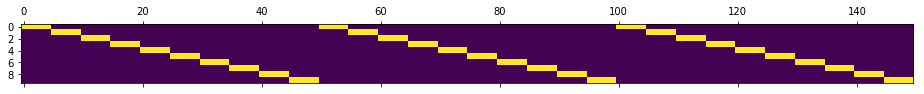

In [29]:
import sklearn.cross_validation as cv

# Helper to plot scikit CV

def plot_cv(cv):
    masks = []
    for train, test in cv: # this shows you how to use the cv results!
        # i.e. X_train, y_train = X[train], y[train]
        mask = np.zeros(cv.n, dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks)
    
kfold = cv.StratifiedKFold(y, n_folds=10) # using it on the original multi-class labels
plot_cv(kfold)

It is interesting to note how the folds partition into the regions of the three class labels.

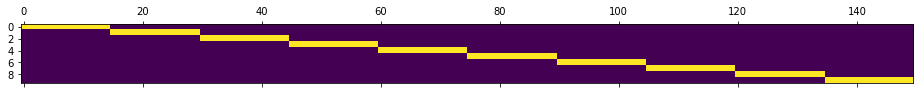

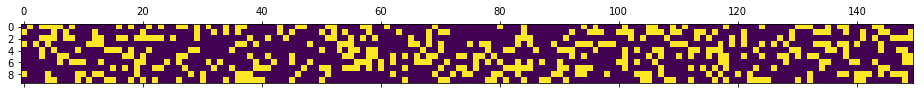

In [31]:
# Other CV methods do not require labels only the length of the labels
plot_cv(cv.KFold(len(y), n_folds=10)) # like we implemented
plot_cv(cv.ShuffleSplit(len(y), n_iter=10, test_size=0.3)) # like training_test_split with test 30% of data

<b>Ex. 2.2</b>: Using the whole dataset build any classifier that detects iris virginica. 
Try two cross validation strategies:

a) stratified 2-fold CV

b) LOOCV (leave one out cross validation)

Choose the best models in a) and b). Compare those two models, which one is likely to be better? What do the ROC curves tell you? Should an additional holdout set be used?

Hint: The accuracy is the mean of the accuracy on every test set. In LOOCV this is the one test sample. Thus, the overall accuracy is equivalent to the ratio of folds in which the test sample was correctly predicted. 

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

base_clf = LogisticRegression(C=1, solver="saga", multi_class="multinomial")

param = {
    "C": [0.03, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ("l1", "l2")
}

clf = GridSearchCV(base_clf, param, scoring="accuracy", cv=ShuffleSplit(3), verbose=1)
scores = cross_val_score(clf, X, y, scoring="accuracy", cv=ShuffleSplit(5), n_jobs=-1, verbose=1)

print("%.4f (±%.4f)" % (np.mean(scores), np.std(scores)))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.6s finished
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Co

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

0.9867 (±0.0267)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [34]:
clf.fit(X, y)
y_pred = clf.predict_proba(X)

mask = y_pred >= 0.5
y_pred[mask] = 1
y_pred[~mask] = 0
y_pred

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uberwach/anaconda2/envs/python35/lib/python3.

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.

In [ ]:
# Exercise 2.2

/Users/uberwach/anaconda2/envs/python35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best Classifier (2-fold): SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy (2-fold): 0.6666666666666666


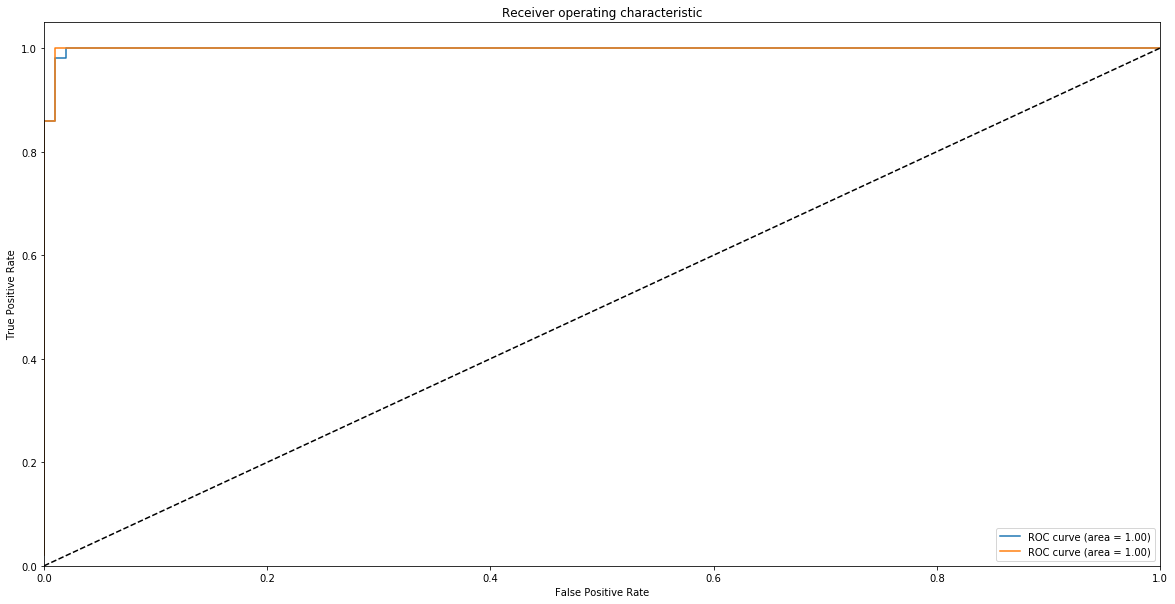

Best Classifier (LOOCV): SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Best Accuracy (LOOCV): 0.9866666666666667


In [36]:
# Solution Exercise 2.2

virgin_idx = y == 2
y_virgin = np.zeros(len(y))
y_virgin[virgin_idx] = 1

from sklearn import grid_search
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold

parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
}

svc = SVC()

# a)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold(y_virgin, 2))
clf.fit(X, y_virgin) 

best_clf_a = clf.best_estimator_

y_score = best_clf_a.decision_function(X)
fpr_a, tpr_a, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)

print('Best Classifier (2-fold): {}'.format(best_clf_a))
print('Best Accuracy (2-fold): {}'.format(clf.best_score_))
# b)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=LeaveOneOut(150))
clf.fit(X, y_virgin)   

best_clf_b = clf.best_estimator_

y_score = best_clf_b.decision_function(X)
fpr_b, tpr_b, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)
plot_roc_curves([fpr_a, fpr_b], [tpr_a, tpr_b])

print('Best Classifier (LOOCV): {}'.format(best_clf_b))
print('Best Accuracy (LOOCV): {}'.format(clf.best_score_))

### Validation curves

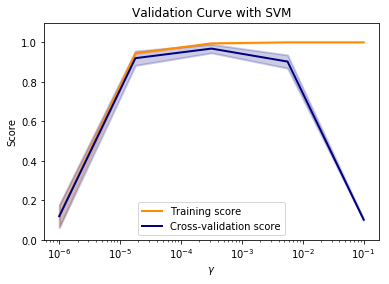

In [37]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## 3. Wrapping up: Politician recognition

This section is optional and supposed to be a playground to try out things presented in the lectures so far. Running the next cell loads the data set that loads about 1300 images of politicians of the era of the war in Iraq. As this data set is about 200 MB this can take a while.

In [ ]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
print 'Loaded {} data points with {} features'.format(lfw_people.data.shape[0], lfw_people.data.shape[1])
print 'Names of politicians: {}'.format(lfw_people.target_names)

The following code plots some images, feel free to use it.

In [ ]:
fig = plt.figure(figsize=(12, 8))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[]) # xticks / yticks = [] ensures no border
    ax.imshow(lfw_people.images[i], cmap=plt.cm.bone)
    ax.set_title(lfw_people.target_names[lfw_people.target[i]])

<b>Ex. 3.1 (Optional)</b>: Train a classifier for the politician recognition problem. Ideally, you should solve the multiclass problem and use CV and scoring techniques. You can also train a binary classifier to detect one of the politicians.

Show what you can!

In [ ]:
# simple train test split (can be used, but you can also do CV based approaches).
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=3)